# [Bonus Tasks](svm_segm.ipynb)

In [87]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [88]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [89]:
patch_sizes = (32, 32)

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [90]:
def create_data_matrix (img) :
    block = skimage.util.view_as_blocks(img, block_shape = patch_sizes) # Bild in Patches aufteilen
    n_blocks_x = block.shape[0] # Anzahl der Patches in x-Richtung
    n_blocks_y = block.shape[1] # Anzahl der Patches in y-Richtung
    X = [] # Liste für die Patches
    for i in range(n_blocks_x) : # Schleife über alle Patches in x-Richtung
        for j in range(n_blocks_y) : # Schleife über alle Patches in y-Richtung
            patch = block[i, j, :, :].flatten() # Patch in einen Vektor umwandeln
            X.append(patch) # Patch zur Liste hinzufügen

    return np.array(X) # Ergebnis ist eine 2D Matrix mit den Patches als Zeilen

**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [91]:
def create_gt_labels_vector (img) :
    block = skimage.util.view_as_blocks(img, block_shape = patch_sizes) #Bild in Patches aufteilen
    n_blocks_x = block.shape[0] # Anzahl der Patches in x-Richtung
    n_blocks_y = block.shape[1] # Anzahl der Patches in y-Richtung
    y = [] # Liste für die Labels
    for i in range(n_blocks_x) : # Schleife über alle Patches in x-Richtung
        for j in range(n_blocks_y) : # Schleife über alle Patches in y-Richtung
            patch = block[i, j, :, :] # Patch extrahieren 
            if np.mean(patch) > 0.5 : # Wenn der Mittelwert des Patches größer als 0.5 ist Label 1
                y.append(1) 
            elif np.mean(patch) == 0 : # Wenn der Mittelwert des Patches gleich 0 ist Label -1
                y.append(-1)
            else : # Ansonsten Label 0
                y.append(0)
    return np.array(y)

**[Task 1.3.]()** Create the SVM classifier:

In [92]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

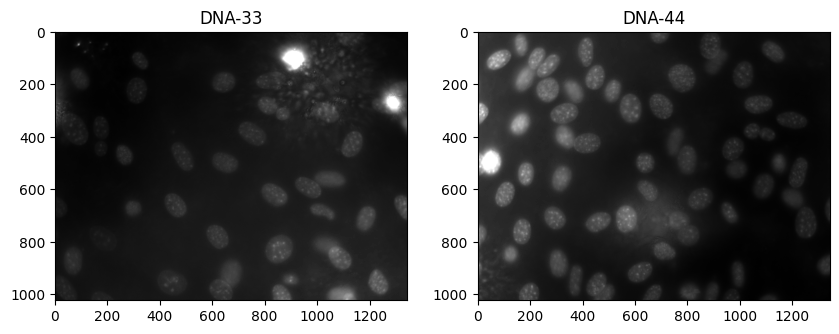

In [93]:
img_dna33 = plt.imread('data/NIH3T3/im/dna-33.png')
img_dna44 = plt.imread('data/NIH3T3/im/dna-44.png')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_dna33, 'gray')
plt.title('DNA-33')
plt.subplot(1,2,2)
plt.imshow(img_dna44, 'gray')
plt.title('DNA-44')
plt.show()

#create the data matrix for the images dna33 and dna44
X_dna33 = create_data_matrix(img_dna33)
X_dna44 = create_data_matrix(img_dna44)

**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [94]:
# create the corresponding ground truth labels
gt_dna33 = plt.imread('data/NIH3T3/gt/33.png') > 0.5 
gt_dna44 = plt.imread('data/NIH3T3/gt/44.png') > 0.5   
n_blocks_x = gt_dna33.shape[0] // patch_sizes[0] # Anzahl der Patches in x-Richtung
n_blocks_y = gt_dna33.shape[1] // patch_sizes[1] # Anzahl der Patches in y-Richtung


**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [95]:
# create the combined data matrix and label vector use np.concatenate
X_train = np.concatenate((X_dna33, X_dna44), axis=0) 
y_train = np.concatenate((create_gt_labels_vector(gt_dna33), create_gt_labels_vector(gt_dna44)), axis=0)



**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [96]:
clf.fit(X_train, y_train) # trainieren des SVM

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [97]:
# implement the function perdict_image
def predict_image(img, clf) : #vorhersage eines Bildes mit dem trainierten SVM-Klassifikator
    X = create_data_matrix(img) #Erstellen der Datenmatrix für das Bild
    prediction = clf.predict(X) #Vorhersage der Labels für die Patches
    result = np.zeros(img.shape, dtype=bool) #Erstellen eines leeren Ergebnisbildes
    n_blocks_x = img.shape[0] // patch_sizes[0] #Anzahl der Patches in x-Richtung
    n_blocks_y = img.shape[1] // patch_sizes[1] #Anzahl der Patches in y-Richtung
    for i in range(n_blocks_x) : #Schleife über alle Patches in x-Richtung
        for j in range(n_blocks_y) : #Schleife über alle Patches in y-Richtung
            if prediction[i * n_blocks_y + j] == 1 : #Wenn das vorhergesagte Label 1 ist wird die entsprechenden Region im Ergebnisbild auf True gesetzt
                seg = result    
                result[i*patch_sizes[0]:(i+1)*patch_sizes[0], j*patch_sizes[1]:(j+1)*patch_sizes[1]] = True 
    return seg
    

Test your implementation:

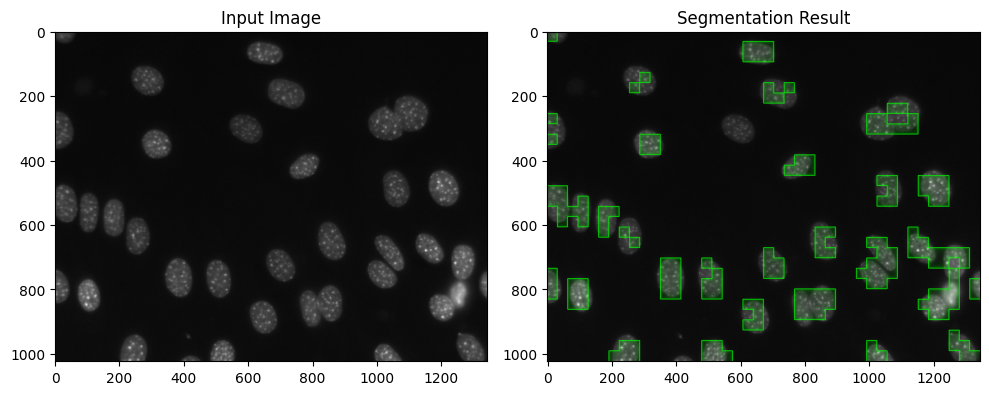

In [98]:
img = plt.imread('data/NIH3T3/im/dna-0.png')
seg = predict_image(img, clf) #Vorhersage des Segmentierungsbildes

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.title('Input Image')
plt.subplot(1,2,2)
plt.imshow(blend_result(img, seg))
plt.title('Segmentation Result')
plt.tight_layout()


**[Task 1.5.]()** Perform batch processing:

FileNotFoundError: [Errno 2] No such file or directory: 'data/NIH3T3/im/dna-2.png'